In [1]:
#Test to figure out how much data is needed for training
import mne
import scipy.io as sp
import numpy as np
import random
import pandas as pd
import multiprocessing as mp
import concurrent.futures
from mne.decoding import CSP
import pymrmr
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier as RF
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import logging
from scipy.signal import kaiser
import os
from collections import Counter



In [22]:
number_of_channels = 64
epoch_length = 1123
SWITCH_WINDOW_LENGTH = epoch_length
CONTINIOUS_WINDOW_LENGTH = 1000
sampling_freq = 250
number_of_runs = 10
number_of_splits = 10
number_of_components = 10
number_of_selected_features = 10
number_of_processes = 15
number_of_bands = 9
# rf = pd.DataFrame()
column_names = ['participant', 'class1', 'class2','running_time','test_acc','train_acc','test_size','train_size','train_block','test_block']
column_names_v2 = ['participant', 'class1', 'class2','running_time','test_acc','train_acc','test_size','train_size','train_block','test_block','test_acc_vote']

# rf = rf.reindex(columns=column_names)


In [4]:
# #Frame Maker
# df = pd.read_csv("frame.csv")
# for i in range(2,16):
#     if i!=9:
#         df.to_csv('P'+str(i)+'.csv',index=False)
    

In [4]:
def calc_csp(x_train, y_train, x_test):
    
        csp = CSP(number_of_components)
        csp_fit = csp.fit(x_train, y_train)
        train_feat = csp_fit.transform(x_train)
        test_feat = csp_fit.transform(x_test)
        return train_feat, test_feat

In [5]:
def class_extraction(number_of_epochs, class_1, class_2, data, labels):
    size = sum(labels[:,0] == class_1) + sum(labels[:,0] == class_2)
    Final_labels = np.zeros((size,1)).astype(int)
    dataset = np.zeros((size,number_of_channels, epoch_length))
    index = 0
    for i in range(number_of_epochs):
        if labels[i,0] == class_1 or labels[i,0] == class_2:
            dataset[index,:,:] = data[i,:,:]
            Final_labels[index,0] = labels[i,0]
            index = index + 1
        else:
            continue
            
    return dataset, Final_labels

In [6]:
def feature_extraction(dataset, labels, number_of_bands, test_data):

    low_cutoff = 0
    
    for b in range(number_of_bands):
        logging.getLogger('mne').setLevel(logging.WARNING)
        low_cutoff += 4
        data = dataset.copy()
        data_test = test_data.copy()
        filtered_data = mne.filter.filter_data(data, sampling_freq, low_cutoff, low_cutoff + 4, verbose = False, n_jobs = 4)
        filtered_data_test = mne.filter.filter_data(test_data, sampling_freq, low_cutoff, low_cutoff + 4, verbose = False, n_jobs = 4)
        [train_feats, test_feats] = calc_csp(filtered_data, labels[:,0], filtered_data_test)
        if b == 0:
            train_features = train_feats
            test_features = test_feats
        else:
            train_features = np.concatenate((train_features, train_feats), axis = 1)
            test_features = np.concatenate((test_features, test_feats), axis = 1)
    
    return train_features, test_features

In [7]:
def feature_selection(train_features, labels, number_of_selected_features):
    X = pd.DataFrame(train_features)
    y = pd.DataFrame(labels)
    K = number_of_selected_features
    
    df = pd.concat([y,X], axis = 1)
    df.columns = df.columns.astype(str)
        
    selected_features = list(map(int, pymrmr.mRMR(df, 'MID', K)))
    return selected_features

In [8]:
def data_reader(path):
    data = mne.read_epochs_eeglab(path)
    data = data.to_data_frame()
    return data

In [9]:
# data.tail()
def left_epoch_finder(data):
    cutdata = data[data['condition']=='Left']
    left_epochs_list = cutdata['epoch'].unique()
    return left_epochs_list

In [12]:
def find_starting_points(numbers):
    starting_points = []
    current_group = []

    for i, num in enumerate(numbers):
        if i == 0 or num != numbers[i-1] + 1:
            # Start of a new group
            current_group = [num]
            starting_points.append(num)
        else:
            current_group.append(num)

    return starting_points


In [11]:
def preprocessor(X_train_df,X_test_df,data):
    
    X1 = X_train_df[X_train_df.columns[3:]].to_numpy()
    X1 = np.transpose(X1)
    print(X1.shape)
    
    X2 = X_test_df[X_test_df.columns[3:]].to_numpy()
    X2 = np.transpose(X2)  
    # number_of_epochs_tr = int(len(X_train_df)/epoch_length)
    # number_of_epochs_te = int(len(X_test_df)/epoch_length)
    
    epoch_range_X_tr = X_train_df['epoch'].unique()
    epoch_range_data = data['epoch'].unique()
    epoch_range_X_te = X_test_df['epoch'].unique()
    a = epoch_range_X_tr
    b = epoch_range_data
    c = epoch_range_X_te
    # print(a,b,"ab")
    number_of_epochs_tr= a[-1]-a[0]+1
    number_of_epochs_te = c[-1]-c[0]+1
    thr_up = a[-1]
    thr_dw = a[0]
    period = a[-1]-a[0]+1
    number_of_epochs_all = b[-1]-b[0]+1
    thr_dw_te = c[0]
    # number_of_epochs_te = number_of_epochs_all-number_of_epochs_tr
    print(number_of_epochs_te,"number_of_epochs_te")
    # random.seed(42)
    randomlist_all = random.sample(range(b[0],b[-1]+1),number_of_epochs_all)
    randomlist_tr = random.sample(range(a[0],a[-1]+1),number_of_epochs_tr)
    randomlist_te = random.sample(range(c[0],c[-1]+1),number_of_epochs_te)
    print(c[0],c[-1],"c0c-1")
    # randomlist_te = [i for i in randomlist_all if i not in randomlist_tr]
    # print(randomlist_te,"randomlist_te")
    # print(randomlist_te)
    
    # randomlist_tr = random.sample(range(number_of_epochs_tr), number_of_epochs_tr)
    # randomlist_te = random.sample(range(number_of_epochs_tr,(number_of_epochs_tr+number_of_epochs_te)),number_of_epochs_te)

    data_tr = np.zeros((number_of_epochs_tr,num_channels, epoch_length))
    labels_tr = np.zeros((number_of_epochs_tr,1)).astype(int)
    
    data_te = np.zeros((number_of_epochs_te,num_channels, epoch_length))
    labels_te = np.zeros((number_of_epochs_te,1)).astype(int)

    for i in range(number_of_epochs_tr):
        # print(randomlist_tr[i])
        c = 1 if randomlist_tr[i]>=period else 0
        d = randomlist_tr[i]-(c*thr_dw)
        data_tr[i,:,:] = X1[:, d*epoch_length:(d + 1)*epoch_length]
        if (X_train_df['condition'][randomlist_tr[i]*epoch_length] == 'Left'):
            labels_tr[i,0] = 0
        elif(X_train_df['condition'][randomlist_tr[i]*epoch_length] == 'Right'):
            labels_tr[i,0] = 1
        elif(X_train_df['condition'][randomlist_tr[i]*epoch_length] == 'Feet'):
            labels_tr[i,0] = 2
        elif(X_train_df['condition'][randomlist_tr[i]*epoch_length] == 'Tongue'):
            labels_tr[i,0] = 3
        elif(X_train_df['condition'][randomlist_tr[i]*epoch_length] == 'Mis'):
            labels_tr[i,0] = 4
        elif(X_train_df['condition'][randomlist_tr[i]*epoch_length] == 'Si'):
            labels_tr[i,0] = 5
        elif(X_train_df['condition'][randomlist_tr[i]*epoch_length] == 'Rest'):
            labels_tr[i,0] = 6
        else:
            raise Exception("Labeling Error!!!")          
      
    for i in range(number_of_epochs_te):
        # print(randomlist_te[i],"test")
        # print(thr_up,"thr_up")
        # print(period,"period")
        # print(d,"d")
        # c = 1 if randomlist_te[i]>thr_up else 0
        # d = randomlist_te[i] - (c*period)
        d = randomlist_te[i]-thr_dw_te
        data_te[i,:,:] = X2[:, d*epoch_length:(d + 1)*epoch_length]
        if (X_test_df['condition'][randomlist_te[i]*epoch_length] == 'Left'):
            labels_te[i,0] = 0
        elif(X_test_df['condition'][randomlist_te[i]*epoch_length] == 'Right'):
            labels_te[i,0] = 1
        elif(X_test_df['condition'][randomlist_te[i]*epoch_length] == 'Feet'):
            labels_te[i,0] = 2
        elif(X_test_df['condition'][randomlist_te[i]*epoch_length] == 'Tongue'):
            labels_te[i,0] = 3
        elif(X_test_df['condition'][randomlist_te[i]*epoch_length] == 'Mis'):
            labels_te[i,0] = 4
        elif(X_test_df['condition'][randomlist_te[i]*epoch_length] == 'Si'):
            labels_te[i,0] = 5
        elif(X_test_df['condition'][randomlist_te[i]*epoch_length] == 'Rest'):
            labels_te[i,0] = 6
        else:
            raise Exception("Labeling Error!!!")
     
    return data_tr,data_te,labels_tr,labels_te,number_of_epochs_tr,number_of_epochs_te
    

In [14]:
# df = pd.DataFrame(columns=column_names)
# df.to_csv('frame.csv',index=False)

In [ ]:
left_epochs_list = left_epoch_finder(data)
# print(left_epochs_list)
starting_left_epochs = find_starting_points(left_epochs_list)
starting_left_samples = [epoch_length* item for item in starting_left_epochs]
print(starting_left_samples)

[0, 78610, 157220, 235830, 314440, 393050, 471660]


In [ ]:
df = pd.read_csv('P2.csv')

In [ ]:
df = pd.read_csv('P2.csv')
fdfr = df[(df['train_block'] == 1) & (df['class1'] == 'Right')]
fdfs = df[(df['train_block'] == 1) & (df['class1'] == 'Si')]
fdfr.head(10)

,participant,class1,class2,running_time,test_acc,train_acc,test_size,train_size,train_block,test_block
0,2,Right,Rest,6.338198,1.00,1.0,"(20, 64, 1123)","(20, 64, 1123)",1,2
2,2,Right,Rest,4.512489,0.80,1.0,"(20, 64, 1123)","(20, 64, 1123)",1,3
4,2,Right,Rest,4.500768,0.80,1.0,"(20, 64, 1123)","(20, 64, 1123)",1,4
6,2,Right,Rest,4.496808,0.90,1.0,"(20, 64, 1123)","(20, 64, 1123)",1,5
8,2,Right,Rest,4.523510,0.75,1.0,"(20, 64, 1123)","(20, 64, 1123)",1,6
10,2,Right,Rest,4.672908,0.90,1.0,"(20, 64, 1123)","(20, 64, 1123)",1,7


In [ ]:
right = fdfr["test_acc"].tolist()
si = fdfs["test_acc"].tolist()
x_axis = fdfr["test_block"].tolist()
print(si,right)


[0.65, 0.9, 0.6, 0.6, 0.65, 0.7] [1.0, 0.8, 0.8, 0.9, 0.75, 0.9]


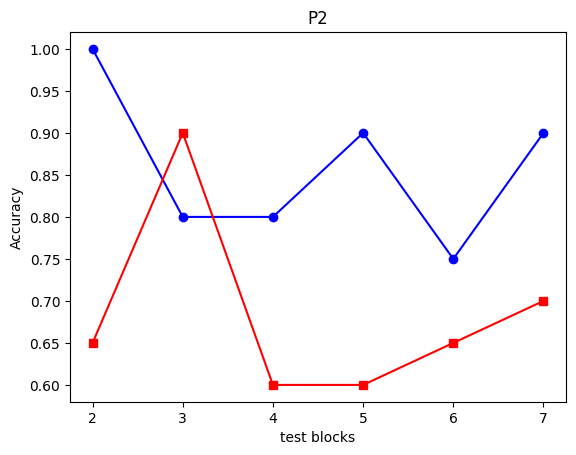

In [15]:
x =x_axis
y1 = right
y2 = si
plt.plot(x, y1, label='right', color='blue', marker='o')
plt.plot(x, y2, label='si', color='red', marker='s')

plt.xlabel('test blocks')
plt.ylabel('Accuracy')
plt.title('P2')
plt.show()

# plt.savefig('TimeSiVsRest.jpg', format='jpeg')

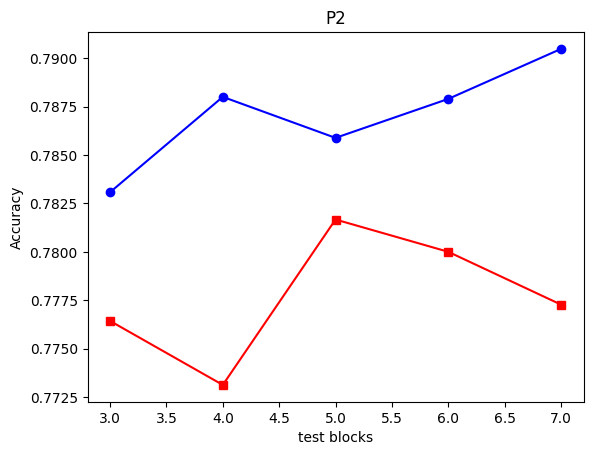

In [19]:
fdfr = df[(df['train_block'] == 12) & (df['class1'] == 'Right')]
fdfs = df[(df['train_block'] == 12) & (df['class1'] == 'Si')]
right = fdfr["test_acc"].tolist()
si = fdfs["test_acc"].tolist()
x_axis = fdfr["test_block"].tolist()
x =x_axis
y1 = right
y2 = si
plt.plot(x, y1, label='right', color='blue', marker='o')
plt.plot(x, y2, label='si', color='red', marker='s')

plt.xlabel('test blocks')
plt.ylabel('Accuracy')
plt.title('P2')
plt.show()

## Side Analysis

In [13]:
p_num_list = [2,3,4,5,6,7,8,10,11,12,13,14,15]
data_dict = {}
for P_num in p_num_list:
    data = data_reader('/project/6067835/mahdi146/Cedar/Data/P'+str(P_num)+'.set')
    data_dict[P_num] = data

Extracting parameters from /project/6067835/mahdi146/Cedar/Data/P2.set...


/tmp/ipykernel_32150/2716586413.py:2: RuntimeWarning: Unknown types found, setting as type EEG:
ref: ['FCz']
  data = mne.read_epochs_eeglab(path)


Not setting metadata
490 matching events found
No baseline correction applied
0 projection items activated
Ready.
Extracting parameters from /project/6067835/mahdi146/Cedar/Data/P3.set...


/tmp/ipykernel_32150/2716586413.py:2: RuntimeWarning: Unknown types found, setting as type EEG:
ref: ['FCz']
  data = mne.read_epochs_eeglab(path)
/tmp/ipykernel_32150/2716586413.py:2: RuntimeWarning: Channel names are not unique, found duplicates for: {'FCz'}. Applying running numbers for duplicates.
  data = mne.read_epochs_eeglab(path)


Not setting metadata
488 matching events found
No baseline correction applied
0 projection items activated
Ready.
Extracting parameters from /project/6067835/mahdi146/Cedar/Data/P4.set...


/tmp/ipykernel_32150/2716586413.py:2: RuntimeWarning: Unknown types found, setting as type EEG:
ref: ['FCz']
  data = mne.read_epochs_eeglab(path)
/tmp/ipykernel_32150/2716586413.py:2: RuntimeWarning: Channel names are not unique, found duplicates for: {'FCz'}. Applying running numbers for duplicates.
  data = mne.read_epochs_eeglab(path)


Not setting metadata
491 matching events found
No baseline correction applied
0 projection items activated
Ready.
Extracting parameters from /project/6067835/mahdi146/Cedar/Data/P5.set...


/tmp/ipykernel_32150/2716586413.py:2: RuntimeWarning: Unknown types found, setting as type EEG:
ref: ['FCz']
  data = mne.read_epochs_eeglab(path)


Not setting metadata
489 matching events found
No baseline correction applied
0 projection items activated
Ready.
Extracting parameters from /project/6067835/mahdi146/Cedar/Data/P6.set...


/tmp/ipykernel_32150/2716586413.py:2: RuntimeWarning: Unknown types found, setting as type EEG:
ref: ['FCz']
  data = mne.read_epochs_eeglab(path)


Not setting metadata
489 matching events found
No baseline correction applied
0 projection items activated
Ready.
Extracting parameters from /project/6067835/mahdi146/Cedar/Data/P7.set...


/tmp/ipykernel_32150/2716586413.py:2: RuntimeWarning: Unknown types found, setting as type EEG:
ref: ['FCz']
  data = mne.read_epochs_eeglab(path)


Not setting metadata
490 matching events found
No baseline correction applied
0 projection items activated
Ready.
Extracting parameters from /project/6067835/mahdi146/Cedar/Data/P8.set...


/tmp/ipykernel_32150/2716586413.py:2: RuntimeWarning: Unknown types found, setting as type EEG:
ref: ['FCz']
  data = mne.read_epochs_eeglab(path)


Not setting metadata
490 matching events found
No baseline correction applied
0 projection items activated
Ready.
Extracting parameters from /project/6067835/mahdi146/Cedar/Data/P10.set...


/tmp/ipykernel_32150/2716586413.py:2: RuntimeWarning: Unknown types found, setting as type EEG:
ref: ['FCz']
  data = mne.read_epochs_eeglab(path)


Not setting metadata
490 matching events found
No baseline correction applied
0 projection items activated
Ready.
Extracting parameters from /project/6067835/mahdi146/Cedar/Data/P11.set...


/tmp/ipykernel_32150/2716586413.py:2: RuntimeWarning: Unknown types found, setting as type EEG:
ref: ['FCz']
  data = mne.read_epochs_eeglab(path)


Not setting metadata
490 matching events found
No baseline correction applied
0 projection items activated
Ready.
Extracting parameters from /project/6067835/mahdi146/Cedar/Data/P12.set...


/tmp/ipykernel_32150/2716586413.py:2: RuntimeWarning: Unknown types found, setting as type EEG:
ref: ['FCz']
  data = mne.read_epochs_eeglab(path)


Not setting metadata
490 matching events found
No baseline correction applied
0 projection items activated
Ready.
Extracting parameters from /project/6067835/mahdi146/Cedar/Data/P13.set...


/tmp/ipykernel_32150/2716586413.py:2: RuntimeWarning: Unknown types found, setting as type EEG:
ref: ['FCz']
  data = mne.read_epochs_eeglab(path)


Not setting metadata
488 matching events found
No baseline correction applied
0 projection items activated
Ready.
Extracting parameters from /project/6067835/mahdi146/Cedar/Data/P14.set...


/tmp/ipykernel_32150/2716586413.py:2: RuntimeWarning: Unknown types found, setting as type EEG:
ref: ['FCz']
  data = mne.read_epochs_eeglab(path)


Not setting metadata
490 matching events found
No baseline correction applied
0 projection items activated
Ready.
Extracting parameters from /project/6067835/mahdi146/Cedar/Data/P15.set...


/tmp/ipykernel_32150/2716586413.py:2: RuntimeWarning: Unknown types found, setting as type EEG:
ref: ['FCz']
  data = mne.read_epochs_eeglab(path)


Not setting metadata
490 matching events found
No baseline correction applied
0 projection items activated
Ready.


In [14]:
class Window:
    def __init__(self,param_value,param_name,window_name):
        self.param_value = param_value
        self.param_name = param_name
        self.window_name = window_name

In [45]:

vote_window = 3
classifier_dic = {"LDA":LDA()}
window_type_list = [Window(0,"No_Params","Rec")]
train_blk_set_dic = {"1234":[1,2,3,4],"123":[1,2,3],"12":[1,2],"1":[1]}
number_of_test_blk = 1
epoch_slide_length = 14
# test_blk_set_dic = {"7_1":[7],"7_2":[7],"7_3":[7],"7_4":[7]}
# p_num_list = [3]
p_num_list = [2,3,4,5,6,7,8,10,11,12,13,14,15]
class_1_list = ['Right','Feet','Tongue','Mis']
class_2 = 'Rest'
PATH = '/home/mahdi146/projects/def-b09sdp/mahdi146/Cedar/Classification/EEG-v2/EEG/Results-H_Dataset-v1'
# print(len(data))

for classifier, classifier_name in zip(classifier_dic.values(),classifier_dic.keys()):
    for window_type in window_type_list:
        for train_blk_set,train_blk_name in zip(train_blk_set_dic.values(),train_blk_set_dic.keys()):
            class_1_list = ['Right','Feet','Tongue','Mis']
            for p_num in p_num_list:
                #Left handed participants
                if p_num in [1,7,9]:
                    class_1_list = ['Left','Feet','Tongue','Mis']
                data = data_dict[p_num]
                for index, class_1 in enumerate(class_1_list):
                    import time
                    start_time = time.time()
                    class_1_data = data.copy()
                    class_2_data = data.copy()

                    class_1_data = class_1_data[class_1_data['condition']== class_1]
                    class_2_data = class_2_data[class_2_data['condition']== class_2]
                    df_1 = class_1_data.copy()
                    df_2 = class_2_data.copy()

                    # Train partitioning
                    unique_epochs_ = df_1['epoch'].unique()
                    epoch_mapping_ = {old_epoch: new_epoch for new_epoch, old_epoch in enumerate(unique_epochs_)}
                    df_1['epoch'] = df_1['epoch'].map(epoch_mapping_)

                    unique_epochs = df_2['epoch'].unique()
                    epoch_mapping = {old_epoch: new_epoch for new_epoch, old_epoch in enumerate(unique_epochs)}
                    df_2['epoch'] = df_2['epoch'].map(epoch_mapping)

                    cte_tr = len(train_blk_set)
                    starting_epoch_tr_1 = df_1.iloc[0,2]
                    starting_epoch_tr_2 = df_2.iloc[0,2]
                    end_epoch_tr_2 = end_epoch_tr_1  = cte_tr*epoch_slide_length-1


                    data_1_tr = df_1[(df_1['epoch'] >= starting_epoch_tr_1) & (df_1['epoch'] <= end_epoch_tr_1)]
                    data_2_tr = df_2[(df_2['epoch'] >= starting_epoch_tr_2) & (df_2['epoch'] <= end_epoch_tr_2)]

                    data_tr = pd.concat([data_1_tr, data_2_tr])
                    data_tr.reset_index(drop=True, inplace=True)


                    #Test partitioning
                    df_1_cut = df_1[df_1['epoch']>end_epoch_tr_1]
                    df_2_cut = df_2[df_2['epoch']>end_epoch_tr_2]
                    unique_epochs_te_1 = df_1_cut['epoch'].unique()
                    unique_epochs_te_2 = df_2_cut['epoch'].unique()

                    np.random.seed(42)
                    num_of_test_samples_2 = num_of_test_samples_1 = epoch_slide_length*number_of_test_blk

                    if(num_of_test_samples_1>len(unique_epochs_te_1)):
                        num_of_test_samples_1 = len(unique_epochs_te_1)
                    else:
                        num_of_test_samples_1 = epoch_slide_length*number_of_test_blk
                    
                    if(num_of_test_samples_2>len(unique_epochs_te_2)):
                        num_of_test_samples_2 = len(unique_epochs_te_2)
                    else:
                        num_of_test_samples_2 = epoch_slide_length*number_of_test_blk
                    
                    print(num_of_test_samples_1,len(unique_epochs_te_1),"selected_epochs_1")
                    print(num_of_test_samples_2,len(unique_epochs_te_2),"selected_epochs_2")

                    selected_epochs_1 = np.random.choice(unique_epochs_te_1, size=num_of_test_samples_1, replace=False)
                    selected_epochs_2 = np.random.choice(unique_epochs_te_2, size=num_of_test_samples_2, replace=False)

                    data_1_te = df_1_cut[df_1_cut['epoch'].isin(selected_epochs_1)]

                    data_2_te = df_2_cut[df_2_cut['epoch'].isin(selected_epochs_2)]

                    data_te = pd.concat([data_1_te, data_2_te])
                    data_te.reset_index(drop=True, inplace=True)
                    X_train,y_train = data_label_attacher(data_tr,class_1,class_2,window_type)
                    X_test,y_test = data_label_attacher(data_te,class_1,class_2,window_type)
                    # print(y_train, y_test)



                    [X_train_features, X_test_features] = feature_extraction(X_train, y_train, number_of_bands, X_test)                          
                    selected_features = feature_selection(X_train_features, y_train, number_of_selected_features)  
                    print(X_train_features.shape,"X_train_features.shape")
                    print(y_train.shape,"y_train.shape")
                    # clf = RF(n_jobs=-1,random_state=42)
                    # clf = RF(n_jobs=-1)
                    clf = classifier
                    runs = 1
                    train_acc_list = []
                    test_acc_list = []
                    vote_acc_list = []
                    # selected_features = np.arange(0,X_train_features.shape[1],1)
                    for r in range(runs):
                        if np.isnan(X_train_features[:, selected_features]).any() or np.isinf(X_train_features[:, selected_features]).any():
                            raise ValueError("Input data contains NaNs or Infs.")
                        print(X_train_features[:, selected_features].shape, y_train[:,0].shape)
                        print(selected_features)
                        clf.fit(X_train_features[:, selected_features], y_train[:,0])

                        y_pr_te = clf.predict(X_test_features[:, selected_features])
                        y_pr_tr = clf.predict(X_train_features[:,selected_features])

                        accuracy_te = accuracy_score(y_test, y_pr_te)
                        test_acc_list.append(accuracy_te)

                        accuracy_tr = accuracy_score(y_train,y_pr_tr)
                        train_acc_list.append(accuracy_tr)

                        y_pr_te_Vote = majority_vote_sliding_with_prev_v2(y_pr_te,vote_window)
                        Y_te_Vote = majority_vote_sliding_with_prev_v2(y_test.reshape(-1),vote_window)
                        vote_acc, num_of_mismatches ,mismatches_list = custom_accuracy(Y_te_Vote,y_pr_te_Vote)
                        vote_acc_list.append(vote_acc)
                    if class_1 == 'Right' or class_1 == 'Left':
                        class_1 = 'Hand'
                    end_time = time.time()
                    running_time = end_time-start_time
                    participant = p_num
                    class1 = class_1
                    class2 = class_2
                    running_time = running_time
                    test_acc = np.average(test_acc_list)
                    train_acc = np.average(train_acc_list)
                    vote_acc = np.average(vote_acc_list)
                    test_size = X_test.shape
                    train_size = X_train.shape
                    train_block = train_blk_name
                    #TO DO check the test_blk_name  
                    test_block = f'{X_test.shape[0]} randomly chosen!'
                    new_row = [participant, class1, class2,running_time,test_acc,train_acc,test_size,train_size,train_block,test_block,vote_acc]
                    
                    path = os.path.join(
                    PATH,
                    classifier_name,
                    f"{number_of_components}_CSP_Components",
                    f"{number_of_selected_features}-Selected_Features",
                    f"{window_type.window_name}_Window",
                    f"{window_type.param_name}",
                    f"{window_type.param_value}_{window_type.param_name}",
                    f"{train_blk_name}_Train_v2/"
                    )
                    if index == 0:
                        # clean_csv(path + f"P{p_num}.csv")
                        save_csv(new_row, path + f"P{p_num}.csv")
                    else:                                
                        save_csv(new_row, path + f"P{p_num}.csv")
                    
                    print(
                    f"classifier_name = {classifier_name}\n"
                    f"number_of_components = {number_of_components}\n"
                    f"number_of_selected_features = {number_of_selected_features}\n"
                    f"window_type = {window_type.window_name}\n"
                    f"window_param_name = {window_type.param_name},window_param_value = {window_type.param_value} \n"
                    f"train_blk_name = {train_blk_name}\n"
                    f"Participant = {p_num}"
                    )

                    print(train_acc_list,"train",class_1)
                    print(test_acc_list,"test",class_1)
                    
            class_1_list = ['Hand','Feet','Tongue','Mis']
            get_results_average(path,p_num_list,class_1_list)
            
# print(X_train.shape,y_train.shape,X_test.shape,y_test.shape)


# data_te.iloc[15721:].head()

#Lable Attching



# data_1_tr.tail()


# Replace old epoch values with new ones

# class_1_data_drop = class_1_data.drop(columns=['epoch'])

# df_drop = df.drop(columns=['epoch'])

# df_drop.equals(class_1_data_drop)


# x = class_1_data['Fp1'] == df['Fp1']
# x.sum() == len(class_1_data) == len(df)

14 14 selected_epochs_1
14 14 selected_epochs_2
112
(112, 64, 1000) dataset shape
28
(28, 64, 1000) dataset shape
(112, 90) X_train_features.shape
(112, 1) y_train.shape
(112, 10) (112,)
[10, 17, 41, 11, 26, 40, 21, 24, 20, 80]
classifier_name = LDA
number_of_components = 10
number_of_selected_features = 10
window_type = Rec
window_param_name = No_Params,window_param_value = 0 
train_blk_name = 1234
Participant = 2
[0.9821428571428571] train Hand
[1.0] test Hand
14 14 selected_epochs_1
14 14 selected_epochs_2
112
(112, 64, 1000) dataset shape
28
(28, 64, 1000) dataset shape
(112, 90) X_train_features.shape
(112, 1) y_train.shape
(112, 10) (112,)
[11, 40, 0, 9, 15, 86, 31, 13, 22, 4]
classifier_name = LDA
number_of_components = 10
number_of_selected_features = 10
window_type = Rec
window_param_name = No_Params,window_param_value = 0 
train_blk_name = 1234
Participant = 2
[1.0] train Feet
[0.9285714285714286] test Feet
14 14 selected_epochs_1
14 14 selected_epochs_2
112
(112, 64, 1000) d

In [15]:
def majority_vote_sliding_with_prev_v2(prediction_list, window_size=3):
    majority_votes = []
    
    for i in range(len(prediction_list)):
        start_index = max(0, i - window_size + 1)
        window = prediction_list[start_index:i+1]
        counts = Counter(window)
        majority = counts.most_common(1)[0][0]
        majority_votes.append(majority)
        
    return majority_votes

In [16]:
def custom_accuracy(y_true, y_pred):
    mismatches = []
    total = len(y_true)
    mismatch_count = 0
    
    for i, (true_label, pred_label) in enumerate(zip(y_true, y_pred)):
        if true_label != pred_label:
            mismatches.append(i)
            mismatch_count += 1
            
    accuracy = 1 - (mismatch_count / total)
    
    return accuracy, mismatch_count, mismatches

In [17]:
def get_results_average(path,p_num_list,class_list):
    PATH = path
    vf = pd.DataFrame(columns=column_names_v2) 
    for p_num in p_num_list:
        print(p_num)
        rf = pd.read_csv(PATH + "P" + str(p_num) + ".csv")
        vf = pd.concat([vf, rf], ignore_index=True)
    vf.to_csv(PATH+ 'ResultsOfAll.csv', index=False)

    columnNames = ['class','test_acc','vote_acc']
    kf = pd.DataFrame(columns=columnNames)
    kf.to_csv(PATH+'AverageAcc.csv',index=False)
    vf = pd.read_csv(PATH +"ResultsOfAll.csv")
    df = vf
    blk_list = [1234]
    for class_ in class_list:
        gf = df[(df['class1'] == class_)]
        avg_test = gf['test_acc'].mean()
        avg_vote = gf['test_acc_vote'].mean() 
        new_row = [class_, avg_test,avg_vote] 
        new_row_df = pd.DataFrame([new_row], columns=columnNames)
        rf = pd.read_csv(PATH + 'AverageAcc.csv')
        cf = pd.concat([rf, new_row_df], ignore_index=True)
        cf.to_csv(PATH +'AverageAcc.csv',index=False)  
    kf = pd.read_csv(PATH +'AverageAcc.csv') 
    print(kf.head())


In [41]:
def data_label_attacher(data,class_1,class_2,window_type):
    extra_points =   SWITCH_WINDOW_LENGTH - CONTINIOUS_WINDOW_LENGTH
    SLIDING_POINTS = SWITCH_WINDOW_LENGTH
    df = data.copy()
    # print(df.head())
    df_len = len(data)
    number_of_epochs = int(df_len//epoch_length)
    print(number_of_epochs)
    # print(df.head(11235))
    mask = df['condition'] == class_2
    first_occurrence_index = mask.idxmax()
    # print(first_occurrence_index)
    # print(data.iloc[first_occurrence_index-1:].head())


    X = df[df.columns[3:]].to_numpy()
    X = np.transpose(X)

    
    dataset = np.zeros((number_of_epochs,number_of_channels,epoch_length))
    labels = np.zeros((number_of_epochs,1)).astype(int)
    k = 0
    startIdx = int(k * epoch_length)
    endIdx = int((k+1) * epoch_length )
    label = 1
    for i in range(number_of_epochs):
            if (i>=number_of_epochs/2):
                 label = 0
            slice_X = X[:, startIdx:endIdx]
            if window_type.window_name == "Kaiser":
                kaiser_window = kaiser(epoch_length,window_type.param_value)
                slice_X *= kaiser_window

            # elif window_type.window_name == "Hamming":
            #     hamming_window = hamming(WINDOW_SAMPLE_LENGTH)
            #     slice_X *= hamming_window
            
            # elif window_type.window_name == "Hanning":
            #     hanning_window = hann(WINDOW_SAMPLE_LENGTH)
            #     slice_X *= hanning_window
            
            elif window_type.window_name == "Rec":
                pass
            else:
                raise ValueError("Window type is wrong!")
            dataset[i, :, :] = slice_X
            labels[i,0] = label

            startIdx+=SLIDING_POINTS
            endIdx+=SLIDING_POINTS
    modified_dataset = dataset[:, :, extra_points:]
    print(modified_dataset.shape,"dataset shape")

    return modified_dataset,labels

In [20]:
def save_csv(new_row, path):
    absolute_path = os.path.abspath(path)

    # Create the directory if it doesn't exist
    directory = os.path.dirname(absolute_path)
    if not os.path.exists(directory):
        os.makedirs(directory)

    try:
        rf = pd.read_csv(absolute_path)
    except FileNotFoundError:
        rf = pd.DataFrame(columns=column_names_v2)

    new_row_df = pd.DataFrame([new_row], columns=column_names_v2)
    cf = pd.concat([rf, new_row_df], ignore_index=True)
    cf.to_csv(absolute_path, index=False)